<a href="https://colab.research.google.com/github/cemreefe/cmpe493-project/blob/main/493_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip3 install xmltodict

import os
import tarfile
import pandas as pd
import xmltodict
import json
import io   
import math
import pickle

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
def read_file(path):
  with open(path, 'r') as f:
    return f.read()

In [51]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493'):
  os.makedirs('drive/MyDrive/CMPE/CMPE493')

In [52]:
if not os.path.exists('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'):
  !curl https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml --output drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt'):
  !curl https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt --output drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt

if not os.path.exists('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz'):
  !curl https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases/cord-19_2020-07-16.tar.gz --output drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz

In [53]:
if not os.path.exists('2020-07-16'):
  tar = tarfile.open('drive/MyDrive/CMPE/CMPE493/cord-19_2020-07-16.tar.gz', "r:gz")
  tar.extractall()
  tar.close()

In [54]:
df_metadata = pd.read_csv('2020-07-16/metadata.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
del df_metadata['sha'], df_metadata['source_x'], df_metadata['doi'], df_metadata['pmcid'], df_metadata['pubmed_id'], df_metadata['license'], df_metadata['publish_time'], df_metadata['authors'], df_metadata['journal'], df_metadata['mag_id'], df_metadata['who_covidence_id'], df_metadata['arxiv_id'], df_metadata['pdf_json_files'], df_metadata['pmc_json_files'], df_metadata['url'], df_metadata['s2_id']

In [56]:
df_metadata[df_metadata['cord_uid'] == 'ug7v899j']

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...


In [57]:
df_metadata.drop_duplicates(subset='cord_uid', keep='first', inplace=True)

In [58]:
df_metadata

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...
...,...,...,...
192504,z4ro6lmh,Rapid radiological improvement of COVID-19 pne...,NaN
192505,hi8k8wvb,SARS E protein in phospholipid bilayers: an an...,Abstract We report on an anomalous X-ray refle...
192506,ma3ndg41,Italian Society of Interventional Cardiology (...,COVID‐19 pandemic raised the issue to guarante...
192507,wh10285j,"Nimble, Together: A Training Program's Respons...",NaN


In [59]:
topic_relevances = 'topic iter document_id judgement\n' + read_file('drive/MyDrive/CMPE/CMPE493/qrels-covid_d5_j0.5-5.txt')

df_relevances = pd.read_csv(  io.StringIO(topic_relevances)  , sep=" ")
del df_relevances['iter']

df_relevances

,topic,document_id,judgement
0,1,005b2j4b,2
1,1,00fmeepz,1
2,1,010vptx3,2
3,1,0194oljo,1
4,1,021q9884,1
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [60]:
topics_obj = xmltodict.parse(read_file('drive/MyDrive/CMPE/CMPE493/topics-rnd5.xml'))
topics     = json.loads(json.dumps(topics_obj))

topics_dict = {}
for topic in topics['topics']['topic']:
  # a topic has the following fields:
  #  * @number
  #  * narrative
  #  * query
  #  * question
  #topics_dict[topic['@number']] = topic['query'] + ' ' + topic['question'] + ' ' + topic['narrative']
  topics_dict[topic['@number']] = topic['question']

In [61]:
len(topics_dict)

50

# Data so far

* `topics_dict` 
      has `topic-id` for keys, and topic description for values
* `df_relevances` 
      has the following three columns:
      topic	document-id	judgement
* `df_metadata`
      holds information about the documents
      has the following three columns (others are deleted):
      cord_uid	title	abstract


In [62]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
import numpy as np

docs = np.array(df_metadata)
contents = {}

for doc in docs:
  contents[doc[0]] = f'{doc[1]} {doc[2]}'

In [64]:
import string
import re
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
sw = stopwords.words('english')

def preprocess(s):
  s = s.casefold()
  s = s.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
  s = re.sub("\d+", "", s) #Delete numbers
  s = ' '.join([porter_stemmer.stem(word) for word in s.split() if word not in sw or word != 'nan'])
  return s

In [65]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(preprocessor=preprocess)
vectors = vectorizer.fit_transform(list(contents.values()) + list(topics_dict.values()))
'''

'\nfrom sklearn.feature_extraction.text import TfidfVectorizer\n\nvectorizer = TfidfVectorizer(preprocessor=preprocess)\nvectors = vectorizer.fit_transform(list(contents.values()) + list(topics_dict.values()))\n'

In [66]:
'''
doc_vectors = vectors[:-50]
topic_vectors = vectors[-50:]
'''

'\ndoc_vectors = vectors[:-50]\ntopic_vectors = vectors[-50:]\n'

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

#if not os.path.exists("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle"):
#  doc_vectorizer = TfidfVectorizer(preprocessor=preprocess)
#  doc_vectors = doc_vectorizer.fit_transform(list(contents.values()))
#else:
#  doc_vectors = pickle.load(open("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle", "rb"))

#print(len(doc_vectorizer.vocabulary_))


In [68]:
odd_topic_contents  = { key:topics_dict[key] for key in topics_dict.keys() if (int(key) % 2 == 1) }
even_topic_contents = { key:topics_dict[key] for key in topics_dict.keys() if (int(key) % 2 == 0) }

In [69]:
#if not os.path.exists("drive/MyDrive/CMPE/CMPE493/topic_vectors.pickle"):
#  topic_vectorizer = TfidfVectorizer(preprocessor=preprocess,vocabulary=doc_vectorizer.vocabulary_)
#  topic_vectors = topic_vectorizer.fit_transform(odd_topic_contents.values())
#else:
#  topic_vectors = pickle.load(open("drive/MyDrive/CMPE/CMPE493/topic_vectors.pickle", "rb"))


In [70]:
#if not os.path.exists("drive/MyDrive/CMPE/CMPE493/test_topic_vectors.pickle"):
#  test_topic_vectorizer = TfidfVectorizer(preprocessor=preprocess,vocabulary=doc_vectorizer.vocabulary_)
#  test_topic_vectors = test_topic_vectorizer.fit_transform(even_topic_contents.values())
#else:
#  test_topic_vectors = pickle.load(open("drive/MyDrive/CMPE/CMPE493/test_topic_vectors.pickle", "rb"))


In [71]:
doc_vectorizer = TfidfVectorizer(preprocessor=preprocess)
doc_vectors = doc_vectorizer.fit_transform(list(contents.values()))

topic_vectorizer = TfidfVectorizer(preprocessor=preprocess,vocabulary=doc_vectorizer.vocabulary_)
topic_vectors = topic_vectorizer.fit_transform(odd_topic_contents.values())

test_topic_vectorizer = TfidfVectorizer(preprocessor=preprocess,vocabulary=doc_vectorizer.vocabulary_)
test_topic_vectors = test_topic_vectorizer.fit_transform(even_topic_contents.values())

In [72]:
doc_vectors.shape

(191175, 145403)

In [73]:
doc_vectors_dict = {
    docs[i][0] : doc_vectors[i]
    for i in range(0,len(docs))
}

In [74]:
topic_vectors_dict = {
    key : topic_vectors[i]
    for i, key in enumerate(odd_topic_contents.keys())
}

test_topic_vectors_dict = {
    key : test_topic_vectors[i]
    for i, key in enumerate(even_topic_contents.keys())
}

In [75]:
from sklearn.metrics.pairwise import cosine_similarity
#Takes random doc_id and prints most relevant topic
ex_document = df_metadata.sample().cord_uid.to_string().split()[1]
similarity = cosine_similarity(doc_vectors_dict[ex_document],topic_vectors).flatten()

print(ex_document)
print(similarity)
print(np.max(similarity))
print(np.argmax(similarity))
print(contents[ex_document])
print(topics_dict[str(np.argmax(similarity) + 1)])

xn0u0wj6
[0.04259617 0.01848662 0.08963357 0.04753375 0.         0.03905519
 0.04586433 0.01307889 0.04473754 0.03022524 0.05811764 0.04186228
 0.02924179 0.02057592 0.06520146 0.00706218 0.02919355 0.02510095
 0.03556903 0.04501992 0.05540913 0.02252371 0.00762082 0.03291993
 0.04891496]
0.08963357435500742
2
Vascular Epiphytic Medicinal Plants as Sources of Therapeutic Agents: Their Ethnopharmacological Uses, Chemical Composition, and Biological Activities This is an extensive review on epiphytic plants that have been used traditionally as medicines. It provides information on 185 epiphytes and their traditional medicinal uses, regions where Indigenous people use the plants, parts of the plants used as medicines and their preparation, and their reported phytochemical properties and pharmacological properties aligned with their traditional uses. These epiphytic medicinal plants are able to produce a range of secondary metabolites, including alkaloids, and a total of 842 phytochemicals

In [76]:
topic_vectors

<25x145403 sparse matrix of type '<class 'numpy.float64'>'
	with 261 stored elements in Compressed Sparse Row format>

In [77]:
df_evaluation = df_relevances.copy()

In [78]:
# drop odd numbered
df_evaluation = df_evaluation.drop(df_evaluation[df_evaluation.topic.map(int) % 2 == 1].index)

In [79]:
df_evaluation

,topic,document_id,judgement
1647,2,01goni72,2
1648,2,01yc7lzk,0
1649,2,02cy1s8x,0
1650,2,02f0opkr,0
1651,2,03h85lvy,2
...,...,...,...
69313,50,zvop8bxh,2
69314,50,zwf26o63,1
69315,50,zwsvlnwe,0
69316,50,zxr01yln,1


In [80]:
test_topic_vectors_dict.keys()

dict_keys(['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', '24', '26', '28', '30', '32', '34', '36', '38', '40', '42', '44', '46', '48', '50'])

In [81]:
test_topic_vectors_dict['2']

<1x145403 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [82]:
cosine_similarity(test_topic_vectors_dict['2'], doc_vectors_dict['01goni72']).flatten()

array([0.1072643])

In [83]:
df_evaluation['cosine_similarity'] = df_evaluation.apply(
    lambda r: cosine_similarity(test_topic_vectors_dict[str(r.topic)], doc_vectors_dict[r.document_id]).flatten()[0],
    axis=1
)

In [84]:
df_evaluation

,topic,document_id,judgement,cosine_similarity
1647,2,01goni72,2,0.107264
1648,2,01yc7lzk,0,0.199574
1649,2,02cy1s8x,0,0.128954
1650,2,02f0opkr,0,0.068542
1651,2,03h85lvy,2,0.089636
...,...,...,...,...
69313,50,zvop8bxh,2,0.052884
69314,50,zwf26o63,1,0.256301
69315,50,zwsvlnwe,0,0.307854
69316,50,zxr01yln,1,0.197346


In [85]:
stuff = np.abs(np.array(df_evaluation.judgement) - np.array(df_evaluation.cosine_similarity)*2)

In [86]:
np.mean(stuff)

0.6299355030280374

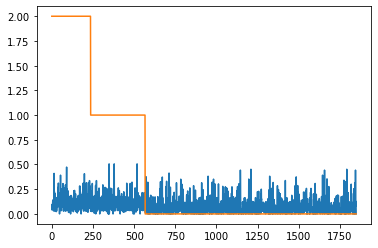

In [87]:
i = 4

similarities = np.array(df_evaluation[df_evaluation['topic'] == i].sort_values(by=["judgement"],ascending=False).cosine_similarity)

import matplotlib.pyplot as plt
plt.plot(similarities)
plt.plot(np.array(df_evaluation[df_evaluation['topic'] == i].sort_values(by=["judgement"],ascending=False).judgement))

In [88]:
import pickle
pickle.dump(doc_vectors, open("drive/MyDrive/CMPE/CMPE493/doc_vectors.pickle", "wb"))
pickle.dump(topic_vectors, open("drive/MyDrive/CMPE/CMPE493/topic_vectors.pickle", "wb"))
pickle.dump(test_topic_vectors, open("drive/MyDrive/CMPE/CMPE493/test_topic_vectors.pickle", "wb"))

In [89]:
#Prepare results
df_results = df_evaluation.copy()
df_results.insert(1, 'iter', 0)
df_results.insert(3, 'rank', 0)
del df_results['judgement']
df_results.insert(5, 'run_id', 0)

In [90]:
df_results

,topic,iter,document_id,rank,cosine_similarity,run_id
1647,2,0,01goni72,0,0.107264,0
1648,2,0,01yc7lzk,0,0.199574,0
1649,2,0,02cy1s8x,0,0.128954,0
1650,2,0,02f0opkr,0,0.068542,0
1651,2,0,03h85lvy,0,0.089636,0
...,...,...,...,...,...,...
69313,50,0,zvop8bxh,0,0.052884,0
69314,50,0,zwf26o63,0,0.256301,0
69315,50,0,zwsvlnwe,0,0.307854,0
69316,50,0,zxr01yln,0,0.197346,0


In [91]:
df_results.to_csv('results.csv', sep=' ', index=False, header=False)

In [94]:
df_results['cosine_similarity'] = np.zeros(df_results.shape[0])

In [95]:
df_results.to_csv('results.csv', sep=' ', index=False, header=False)